<a href="https://colab.research.google.com/github/rayss4lves/redes1/blob/main/q06_redes1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

In [79]:
def gerar_mensagem():
    return random.getrandbits(16)

# Função para introduzir n erros em uma mensagem
def introduzir_erros(mensagem, num_erros):
    if num_erros < 16:
      resultado = mensagem
       # Seleciona num_erros índices aleatórios entre 0 e 15
      bits_invertidos = random.sample(range(16), num_erros)
      # Inverte os bits nas posições selecionadas
      for bit_pos in (bits_invertidos):
        resultado ^= (1 << bit_pos)

    return resultado

In [80]:
def parity_encode(message):
    # Conta o número de bits '1' na mensagem, removendo o prefixo '0b'
    count = bin(message)[2:].count('1')
    # Adiciona o bit de paridade (paridade par)
    return (message * 2) | (count % 2)

def parity_check(mensagem_codificada):
    # Verifica se a paridade está correta, removendo o prefixo '0b'
    count = bin(mensagem_codificada)[2:].count('1')
    return count % 2 == 0

In [81]:
def checksum_(message):

  # Extrai os dois bytes da mensagem (16 bits)
  byte1 = message // 256
  byte2 = message % 256

  # Calcula o checksum: soma dos bytes, mantem 8 bits, e complementa
  checksum = (byte1 + byte2) % 256
  checksum = 255 - checksum

  # Anexa o checksum à mensagem
  return (message * 256) + checksum

def checksum_check(mensagem_codificada):
    # Extrai o checksum e a mensagem
    checksum_recebido = mensagem_codificada % 256
    message = mensagem_codificada //256

    # Recalculando o checksum
    byte1 = message // 256
    byte2 = message % 256

    checksum_calculado = (byte1 + byte2) % 256
    checksum_calculado = 255 - checksum_calculado

    # Verifica se o checksum recebido é igual ao calculado
    return checksum_recebido == checksum_calculado

In [82]:
def crc16_codificado(mensagem):
    if isinstance(mensagem, str):
        mensagem = mensagem.encode('utf-8')

    crc = (2**16 - 1)  # 65535 sem usar 0xFFFF
    polinomial = 0x1021

    for byte in range(16):
        crc = crc ^ (byte * 256)
        for _ in range(8):
            if crc // (2**15):
                crc = (crc * 2) ^ polinomial
            else:
                crc = crc * 2

            # Mantém CRC dentro de 16 bits
            crc = crc % (1 << 16)

    return crc


def crc16_check(mensagem_codificada):
    # Separando a mensagem e o CRC recebido
    mensagem = mensagem_codificada // (2**16)  # Obtém a parte da mensagem
    received_crc = mensagem_codificada % (2**16)  # Obtém o CRC recebido

    crc = (2**16 - 1)  # Inicializa com todos os bits em 1 (65535)
    polinomial = 4129  # Polinômio gerador CRC-16-CCITT (equivalente a 0x1021)

    for _ in range(16):  # Para cada bit da mensagem
        bit = mensagem // (2**15)  # Pega o bit mais significativo
        mensagem = mensagem * 2  # Desloca a mensagem para a esquerda

        # XOR com o polinômio se o bit mais significativo for 1
        if (crc & (2**15)):  # Verifica o bit mais significativo (equivalente a `crc & 0x8000`)
            crc = (crc * 2) ^ polinomial  # Desloca e faz o XOR com o polinômio
        else:
            crc = crc * 2  # Desloca

        # Limita CRC a 16 bits
        crc = crc % (2**16)  # Equivalente a `crc & 0xFFFF`

    return crc == received_crc  # Verifica se o CRC calculado é igual ao CRC recebido



In [83]:
def hamming_encode(message):
    # Convertendo a mensagem para uma string binária de 16 bits
    binary = format(message, '016b')

    # Calculando o número de bits de paridade necessários (2^r >= m+r+1)
    # Para 16 bits de dados, precisamos de 5 bits de paridade
    data_bits = list(binary)

    # Posicionando os bits de dados e reservando espaço para os bits de paridade
    arrCodificado = ['0'] * 21  # 16 bits de dados + 5 bits de paridade

    # Posições de paridade são potências de 2: 1, 2, 4, 8, 16
    posicoes_paridade = [1,2,4,8,16]
    j = 0
    for i in range(1, 22):
        if i not in posicoes_paridade:
            arrCodificado[i-1] = data_bits[j]
            j += 1

    # Calculando os bits de paridade
    for i in posicoes_paridade:
        paridade = 0

        for j in range(1, 22):
            if i & j:
                paridade ^= int(arrCodificado[j-1])

        arrCodificado[i-1] = str(paridade)

    # Convertendo de volta para um inteiro
    return int(''.join(arrCodificado), 2)

def hamming_check_and_correct(mensagem_codificada):
    # Convertendo a mensagem codificada para uma string binária
    binary = format(mensagem_codificada, '021b')
    arrCodificado = list(binary)

    # Verificando os bits de paridade
    error_pos = 0
    for i in range(5):
        pos = 2**i
        paridade = 0

        for j in range(1, 22):
            if j & pos:
                paridade ^= int(arrCodificado[j-1])

        if paridade != 0:
            error_pos += pos

    # Se error_pos for diferente de zero, corrigimos o erro
    corrected = arrCodificado.copy()
    if error_pos > 0 and error_pos <= 21:
        corrected[error_pos-1] = '1' if corrected[error_pos-1] == '0' else '0'

    posicoes_paridade = [1,2,4,8,16]
    # Extraindo os bits de dados originais
    original_data = ''
    for i in range(1, 22):
        if i not in posicoes_paridade:  # Se não é potência de 2
            original_data += corrected[i-1]

    return int(original_data, 2), error_pos > 0

In [84]:
def test_technique(encode_func, check_func, is_correcting=False, name=""):
    num_tests = 10000
    results = {'1_error': 0, '2_errors': 0, '3_errors': 0}
    times = {'codificado': 0, 'check': 0}

    for _ in range(num_tests):
        # Gera uma mensagem original de 16 bits
        mensagem_original = gerar_mensagem()

        # Medindo o tempo de codificação
        inicio = time.time()
        mensagem_codificada = encode_func(mensagem_original)
        times['codificado'] += time.time() - inicio

        # Testando com 1, 2 e 3 erros
        for num_errors in [1, 2, 3]:
            # Introduzindo erros na mensagem codificada
            mensagem_corrompida = introduzir_erros(mensagem_codificada, num_errors)

            # Medindo o tempo de verificação/correção
            inicio = time.time()
            if is_correcting:
                corrected, erro_detectado = check_func(mensagem_corrompida)
                # Verifica se a correção foi bem-sucedida
                if erro_detectado and corrected == mensagem_original:
                    results[f'{num_errors}_error' + ('s' if num_errors > 1 else '')] += 1
            else:
                # Para técnicas que apenas detectam erros
                if check_func(mensagem_corrompida) == False:  # Erro detectado
                    results[f'{num_errors}_error' + ('s' if num_errors > 1 else '')] += 1
            times['check'] += time.time() - inicio

    # Calculando as taxas de detecção/correção
    detection_rates = {k: v / num_tests * 100 for k, v in results.items()}

    # Tempos médios por operação
    avg_times = {k: v / (num_tests * (3 if k == 'check' else 1)) for k, v in times.items()}

    return detection_rates, avg_times

In [85]:
def benchmark_with_scaling():
    # Primeiro, executamos cada técnica uma vez para estimar o tempo
    techniques = [
        (parity_encode, parity_check, False, "Paridade"),
        (checksum_, checksum_check, False, "Checksum"),
        (crc16_codificado, crc16_check, False, "CRC-16"),
        (hamming_encode, lambda x: hamming_check_and_correct(x), True, "Hamming")
    ]

    # Teste inicial para estimar tempos
    times = []
    for encode_func, check_func, is_correcting, name in techniques:
        start = time.time()
        test_technique(encode_func, check_func, is_correcting, name)
        times.append(time.time() - start)

    # Calculando o fator de escala para cada técnica
    min_time = min(times)
    scale_factors = [max(1, int(1.0 / (t / min_time))) for t in times]
    target_time = 2.0  # Garantir que o teste mais rápido leve pelo menos 2 segundos
    scale_multiplier = max(1, int(target_time / min_time))

    scale_factors = [f * scale_multiplier for f in scale_factors]

    print(f"Fatores de escala: {scale_factors}")

    # Executando os testes com os fatores de escala
    all_results = []
    all_times = []

    for (encode_func, check_func, is_correcting, name), scale in zip(techniques, scale_factors):
        print(f"Executando {name} com {scale} iterações...")
        total_start = time.time()

        # Acumuladores para resultados e tempos
        resultados_acumulados = {'1_error': 0, '2_errors': 0, '3_errors': 0}
        tempos_acumulados = {'codificado': 0, 'check': 0}

        for _ in range(scale):
            results, times = test_technique(encode_func, check_func, is_correcting, name)
            for k in resultados_acumulados:
                resultados_acumulados[k] += results[k]
            for k in tempos_acumulados:
                tempos_acumulados[k] += times[k]

        # Calculando médias
        for k in resultados_acumulados:
            resultados_acumulados[k] /= scale
        for k in tempos_acumulados:
            tempos_acumulados[k] /= scale

        total_time = time.time() - total_start

        all_results.append((name, resultados_acumulados))
        all_times.append((name, tempos_acumulados, total_time))

    return all_results, all_times


In [86]:
results, times = benchmark_with_scaling()

Fatores de escala: [14, 14, 14, 14]
Executando Paridade com 14 iterações...
Executando Checksum com 14 iterações...
Executando CRC-16 com 14 iterações...
Executando Hamming com 14 iterações...


In [87]:

# Exibindo resultados em uma tabela
print("\nTaxas de Detecção/Correção de Erros:")
table_data = []
for name, rates in results:
    table_data.append([name, f"{rates['1_error']:.2f}%", f"{rates['2_errors']:.2f}%", f"{rates['3_errors']:.2f}%"])

print(tabulate(table_data, headers=["Técnica", "1 Erro", "2 Erros", "3 Erros"], tablefmt="grid"))

# Exibindo tempos de execução
print("\nTempos de Execução:")
table_data = []
for name, time_data, total in times:
    table_data.append([name, f"{time_data['codificado']*1000:.3f} ms", f"{time_data['check']*1000:.3f} ms", f"{total:.3f} s"])

print(tabulate(table_data, headers=["Técnica", "Codificação (média)", "Verificação (média)", "Tempo Total"], tablefmt="grid"))


Taxas de Detecção/Correção de Erros:
+-----------+----------+-----------+-----------+
| Técnica   | 1 Erro   | 2 Erros   | 3 Erros   |
+===========+==========+===========+===========+
| Paridade  | 100.00%  | 0.00%     | 100.00%   |
+-----------+----------+-----------+-----------+
| Checksum  | 100.00%  | 96.27%    | 99.29%    |
+-----------+----------+-----------+-----------+
| CRC-16    | 100.00%  | 100.00%   | 100.00%   |
+-----------+----------+-----------+-----------+
| Hamming   | 100.00%  | 0.79%     | 0.00%     |
+-----------+----------+-----------+-----------+

Tempos de Execução:
+-----------+-----------------------+-----------------------+---------------+
| Técnica   | Codificação (média)   | Verificação (média)   | Tempo Total   |
+===========+=======================+=======================+===============+
| Paridade  | 0.001 ms              | 0.001 ms              | 1.718 s       |
+-----------+-----------------------+-----------------------+---------------+
| Checksum  

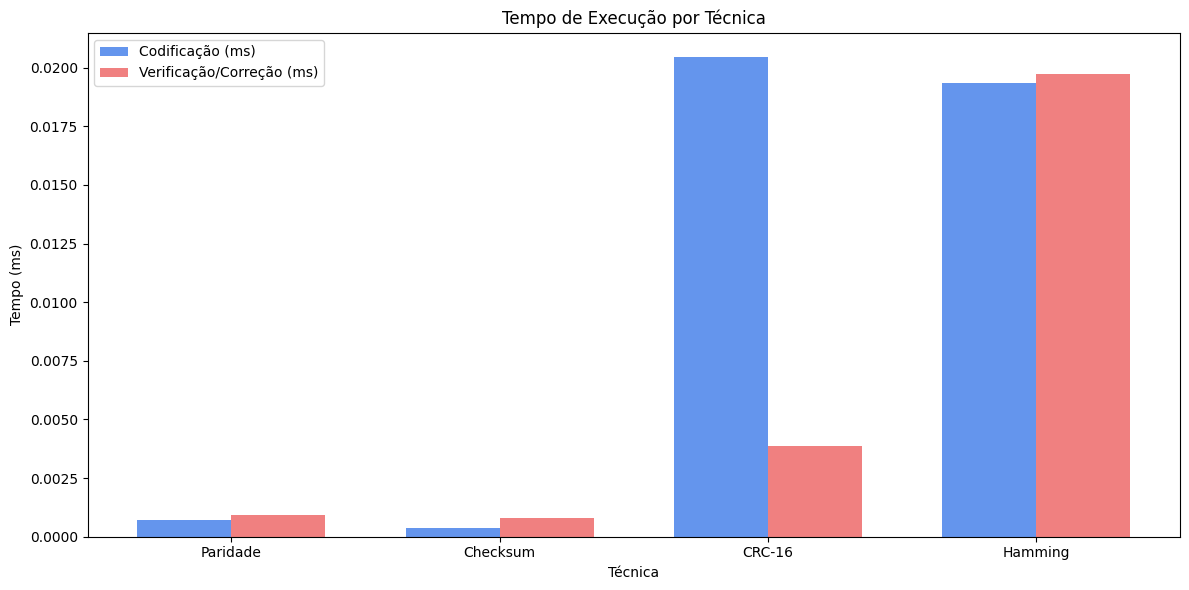

In [88]:
# Dados para o gráfico
technique_names = [t[0] for t in times]
encode_times = [t[1]['codificado']*1000 for t in times]  # Convertendo para milissegundos
check_times = [t[1]['check']*1000 for t in times]    # Convertendo para milissegundos

x = np.arange(len(technique_names))  # Localizações no eixo x
width = 0.35  # Largura das barras

# Criando as barras
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, encode_times, width, label='Codificação (ms)', color='cornflowerblue')
plt.bar(x + width/2, check_times, width, label='Verificação/Correção (ms)', color='lightcoral')

plt.xlabel('Técnica')
plt.ylabel('Tempo (ms)')
plt.title('Tempo de Execução por Técnica')
plt.xticks(x, technique_names)
plt.legend()

# Ajustando o layout e salvando
plt.tight_layout()
plt.savefig('tempos_execucao.png')
plt.show()


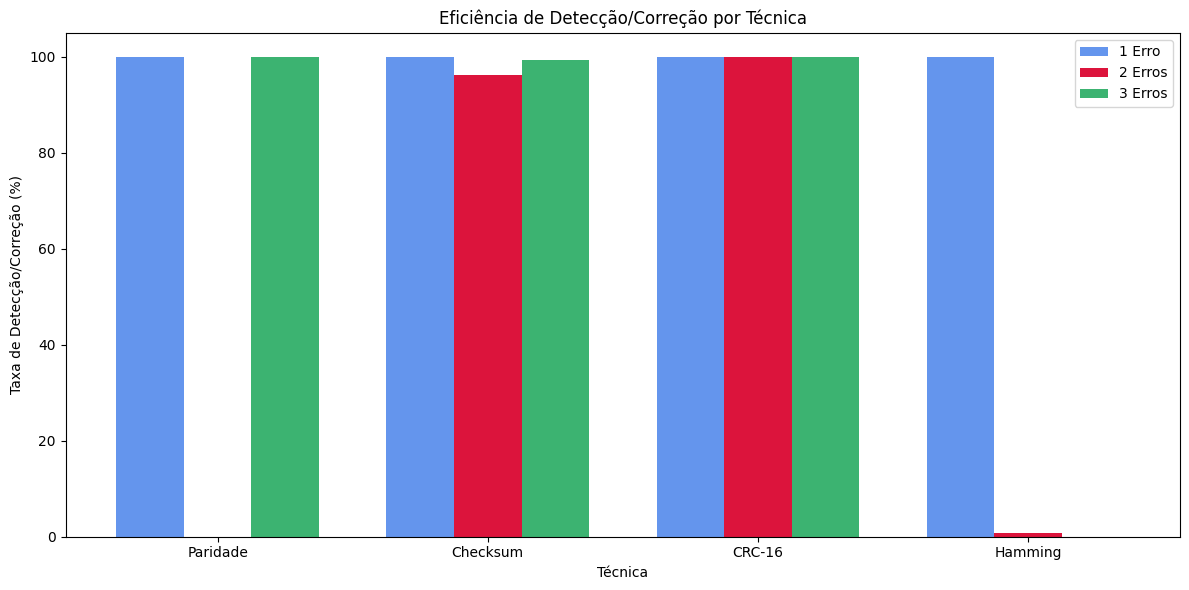

In [89]:
# Criando o gráfico de barras para as taxas de detecção/correção
plt.figure(figsize=(12, 6))
technique_names = [r[0] for r in results]
error1_rates = [r[1]['1_error'] for r in results]
error2_rates = [r[1]['2_errors'] for r in results]
error3_rates = [r[1]['3_errors'] for r in results]

x = np.arange(len(technique_names))  # Localizações no eixo x
width = 0.25  # Largura das barras
colors = ['#6495ED', '#DC143C', '#3CB371']
plt.bar(x - width, error1_rates, width, label='1 Erro', color = colors[0])
plt.bar(x, error2_rates, width, label='2 Erros', color = colors[1])
plt.bar(x + width, error3_rates, width, label='3 Erros', color = colors[2])

plt.xlabel('Técnica')
plt.ylabel('Taxa de Detecção/Correção (%)')
plt.title('Eficiência de Detecção/Correção por Técnica')
plt.xticks(x, technique_names)
plt.legend()

plt.tight_layout()
plt.savefig('eficiencia_deteccao.png')
plt.show()